In [1]:
import copy
from typing import Sequence

import numpy as np
import sympy as smp
import matplotlib.pyplot as plt

from optical_bloch.utils.general import flatten
from optical_bloch import (
    Hamiltonian,
    Dissipator,
    BlochEquations,
    generate_code,
    generate_lindblad_function_julia,
)

plt.rcParams.update({"font.size": 14})


# Toy Λ system

In [2]:
energies = smp.symbols("E0:3", real=True)

omegas = smp.symbols("ω0:2", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:2", real=True)
Gammas = smp.symbols("Γ0:2", real=True)


In [3]:
ham = Hamiltonian(3)
ham.add_energies(energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(1, 2, Omegas[1], omegas[1])

ham.eqn_transform()

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(1, 2, deltas[1])

transformed = ham.transformed - smp.eye(ham.hamiltonian.shape[0]) * energies[2]

transformed


Matrix([
[             -δ0,                0, -Ω0/2],
[               0,              -δ1, -Ω1/2],
[-conjugate(Ω0)/2, -conjugate(Ω1)/2,     0]])

In [4]:
dis = Dissipator(ham.levels)

for idi, idf, Gamma in zip([2, 2], [0, 1], Gammas):
    dis.add_decay(idi, idf, Gamma)

bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)


In [5]:
code, free_parameters = generate_lindblad_function_julia(
    bloch.equations.rhs, bloch.density_matrix, []
)


In [6]:
print(code)

function lindblad!(du, u, p, t)
    	@inbounds begin
    		Ω1 = p[1]
		Γ0 = p[2]
		Ω0 = p[3]
		δ0 = p[4]
		δ1 = p[5]
		Γ1 = p[6]
		du[1,1] = Γ0*u[3,3] + 1.0im*(Ω0*conj(u[1,3]) - u[1,3]*conj(Ω0))/2
		du[1,2] = 1.0im*(Ω0*conj(u[2,3])/2 + δ0*u[1,2] - δ1*u[1,2] - u[1,3]*conj(Ω1)/2)
		du[1,3] = -(Γ0 + Γ1)*u[1,3]/2 - 1.0im*(Ω0*u[1,1] - Ω0*u[3,3] + Ω1*u[1,2] - 2*δ0*u[1,3])/2
		du[2,2] = Γ1*u[3,3] + 1.0im*(Ω1*conj(u[2,3]) - u[2,3]*conj(Ω1))/2
		du[2,3] = -(Γ0 + Γ1)*u[2,3]/2 - 1.0im*(Ω0*conj(u[1,2]) + Ω1*u[2,2] - Ω1*u[3,3] - 2*δ1*u[2,3])/2
		du[3,3] = -(Γ0 + Γ1)*u[3,3] - 1.0im*(Ω0*conj(u[1,3]) + Ω1*conj(u[2,3]) - u[1,3]*conj(Ω0) - u[2,3]*conj(Ω1))/2
	end
	nothing
end


In [7]:
free_parameters

('Ω1', 'Γ0', 'Ω0', 'δ0', 'δ1', 'Γ1')

In [8]:
%%time
steady_state = bloch.solve_steady_state_symbolic(
    replacements=[
        (Gammas[0], 1 / 2),
        (Gammas[1], 1 / 2),
        (deltas[0], 0),
        (deltas[1], 0),
    ]
)


CPU times: total: 484 ms
Wall time: 1.19 s


In [9]:
smp.nsimplify(smp.simplify(steady_state[list(steady_state.keys())[0]].subs([])))


Ω1*conjugate(Ω1)/(Ω0*conjugate(Ω0) + Ω1*conjugate(Ω1))

In [10]:
replacements = [
    (Gammas[0], 1 / 2),
    (Gammas[1], 1 / 2),
    (deltas[0], 0),
    (deltas[1], 0),
    (
        Omegas[0],
        0.5 * ((1 + smp.cos(2 * 3.1415 * 0 * smp.Symbol("t", real=True))) / 2),
    ),
    (Omegas[1], 1),
]

y0 = np.zeros(bloch.levels**2, dtype=complex)
y0[0] = 1 / 2
y0[4] = 1 / 2


In [11]:
from scipy.integrate import solve_ivp

tspan = (0, 50)
method = "RK45"
matrix_eq, t_dependent = bloch.generate_system(replacements)

# ODE solver
if t_dependent:

    def fun(t, rho):
        return matrix_eq(t) @ rho
else:

    def fun(t, rho):
        return matrix_eq @ rho


sol = solve_ivp(fun, tspan, y0, method, vectorized=True, max_step=0.1)


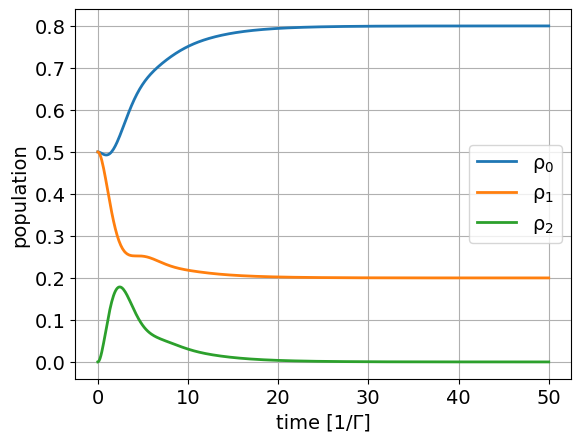

In [12]:
y = sol.y.reshape(bloch.levels, bloch.levels, -1)

fig, ax = plt.subplots()

for idx in range(3):
    ax.plot(sol.t, y[idx, idx].real, lw=2, label=f"ρ$_{idx}$")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")

ax.legend()

ax.grid()


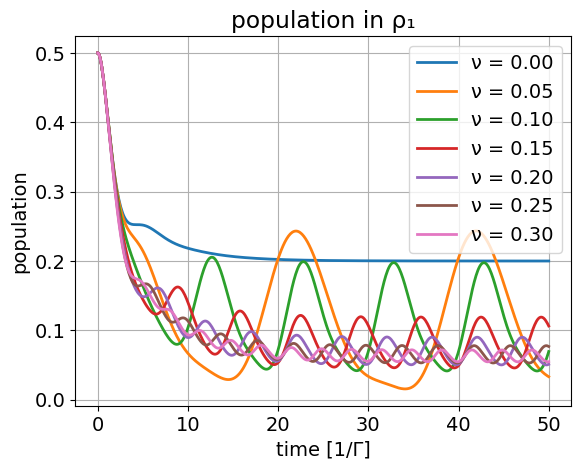

In [13]:
fig, ax = plt.subplots()
for v in np.arange(0, 0.31, 0.05):
    replacements = [
        (Gammas[0], 1 / 2),
        (Gammas[1], 1 / 2),
        (deltas[0], 0),
        (deltas[1], 0),
        (
            Omegas[0],
            0.5 * ((1 + smp.cos(2 * 3.1415 * v * smp.Symbol("t", real=True))) / 2),
        ),
        (Omegas[1], 1),
    ]
    tspan = (0, 50)
    method = "RK45"
    matrix_eq, t_dependent = bloch.generate_system(replacements)

    # ODE solver
    if t_dependent:

        def fun(t, rho):
            return matrix_eq(t) @ rho
    else:

        def fun(t, rho):
            return matrix_eq @ rho

    sol = solve_ivp(fun, tspan, y0, method, vectorized=True, max_step=0.1)

    y = sol.y.reshape(bloch.levels, bloch.levels, -1)

    ax.plot(sol.t, y[1, 1].real, lw=2, label=f"ν = {v:.2f}")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")
ax.set_title("population in ρ₁")

ax.legend()

ax.grid()


In [14]:
%%timeit
sol = solve_ivp(fun, tspan, y0, method="RK45", vectorized=True)


35.2 ms ± 4.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Toy 4 Level Model

In [15]:
ρ = smp.MatrixSymbol("ρ", 4, 4)

energies = smp.symbols("E0:4", real=True)

omegas = smp.symbols("ω0:1", real=True)
Omegas = smp.symbols("Ω0:2", complex=True)
deltas = smp.symbols("δ0:1", real=True)
Gammas = smp.symbols("Γ0:4", real=True)


In [16]:
def couple_manifolds(ham, initial_manifold, final_manifold, rabi, omega):
    if isinstance(rabi, Sequence):
        for idi, idf, r in zip(initial_manifold, final_manifold, rabi):
            ham.add_coupling(idi, idf, r, omega)
    else:
        for idi, idf in zip(initial_manifold, final_manifold):
            ham.add_coupling(idi, idf, rabi, omega)
    return ham


In [17]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham = couple_manifolds(ham, [0, 1], [2, 3], Omegas, omegas[0])


In [18]:
ham.eqn_transform()

In [19]:
ham.hamiltonian

Matrix([
[                               E0,                                 0, -Ω0*exp(1.0*I*t*ω0)/2,                     0],
[                                0,                                E1,                     0, -Ω1*exp(1.0*I*t*ω0)/2],
[-exp(-1.0*I*t*ω0)*conjugate(Ω0)/2,                                 0,                    E2,                     0],
[                                0, -exp(-1.0*I*t*ω0)*conjugate(Ω1)/2,                     0,                    E3]])

In [20]:
ham.transformed

Matrix([
[         E0 + ω0,                0, -Ω0/2,     0],
[               0,          E1 + ω0,     0, -Ω1/2],
[-conjugate(Ω0)/2,                0,    E2,     0],
[               0, -conjugate(Ω1)/2,     0,    E3]])

In [21]:
transformed = smp.Matrix(ham.transformed)
for idx in range(transformed.shape[0]):
    transformed[idx, idx] -= energies[-1]
ham.transformed = smp.nsimplify(transformed)
ham.transformed


Matrix([
[    E0 - E3 + ω0,                0,   -Ω0/2,     0],
[               0,     E1 - E3 + ω0,       0, -Ω1/2],
[-conjugate(Ω0)/2,                0, E2 - E3,     0],
[               0, -conjugate(Ω1)/2,       0,     0]])

In [22]:
def define_state_detuning(hamiltonian, initial, final, detuning):
    energies = hamiltonian.energies

    w = ham.couplings[initial, final]
    if w == 0:
        w = hamiltonian.couplings[final, initial]

    hamiltonian.transformed = hamiltonian.transformed.subs(
        w, energies[final] - energies[initial] - detuning
    )
    return hamiltonian


In [23]:
ham = define_state_detuning(ham, 1, 3, deltas[0])


In [24]:
ham.transformed

Matrix([
[    E0 - E1 - δ0,                0,   -Ω0/2,     0],
[               0,              -δ0,       0, -Ω1/2],
[-conjugate(Ω0)/2,                0, E2 - E3,     0],
[               0, -conjugate(Ω1)/2,       0,     0]])

In [25]:
ham.transformed = ham.transformed.subs(
    energies[0] - energies[1], smp.Symbol("-Δg", real=True)
)
ham.transformed = ham.transformed.subs(
    energies[2] - energies[3], smp.Symbol("-Δe", real=True)
)
ham.transformed


Matrix([
[        -Δg - δ0,                0, -Ω0/2,     0],
[               0,              -δ0,     0, -Ω1/2],
[-conjugate(Ω0)/2,                0,   -Δe,     0],
[               0, -conjugate(Ω1)/2,     0,     0]])

In [26]:
def symbolic_matrix_to_julia(matrix) -> str:
    s = matrix.shape
    matrix_str = "[\n"
    for idx in range(s[0]):
        for idy in range(s[1]):
            matrix_str += f"{str(matrix[idx,idy])} "
        matrix_str += "\n"
    matrix_str += "]"
    matrix_str = matrix_str.replace("conjugate", "conj")
    return matrix_str


In [27]:
def get_symbols_to_julia(matrix) -> str:
    return (
        f"@parameters {str(matrix.free_symbols)}".replace(",", "")
        .replace("{", "")
        .replace("}", "")
        .replace("-", "")
    )


In [28]:
print(get_symbols_to_julia(ham.transformed))

@parameters Ω1 Ω0 Δg Δe δ0


In [29]:
print(symbolic_matrix_to_julia(ham.transformed))

[
-Δg - δ0 0 -Ω0/2 0 
0 -δ0 0 -Ω1/2 
-conj(Ω0)/2 0 -Δe 0 
0 -conj(Ω1)/2 0 0 
]


In [30]:
dis = Dissipator(ham.levels)

for idi, idf, Gamma in zip([2, 2, 3, 3], [0, 1, 0, 1], Gammas):
    dis.add_decay(idi, idf, Gamma)


In [31]:
bloch = BlochEquations(ham.levels, dis.density_matrix, ham.transformed, dis.dissipator)

# Toy 4 Level system with 2 excited states

In [32]:
energies = smp.symbols("E0:4", real=True)

omegas = smp.symbols("ω0:3", real=True)
Omegas = smp.symbols("Ω0:3", complex=True)
deltas = smp.symbols("δ0:3", real=True)
Gammas = smp.symbols("Γ0:2", real=True)


In [33]:
ham = Hamiltonian(energies=energies)
ham.add_coupling(0, 2, Omegas[0], omegas[0])
ham.add_coupling(0, 3, Omegas[1], omegas[1])
ham.add_coupling(1, 2, Omegas[2], omegas[2])
ham.eqn_transform()

ham.define_state_detuning(0, 2, deltas[0])
ham.define_state_detuning(0, 3, deltas[1])
ham.define_state_detuning(1, 2, deltas[2])


In [35]:
ham.transformed

Matrix([
[         E3 - δ1,                 0,        -Ω0/2, -Ω1/2],
[               0, E3 + δ0 - δ1 - δ2,        -Ω2/2,     0],
[-conjugate(Ω0)/2,  -conjugate(Ω2)/2, E3 + δ0 - δ1,     0],
[-conjugate(Ω1)/2,                 0,            0,    E3]])

# Toy Rotational Cooling

In [ ]:
ρ = smp.MatrixSymbol("ρ", 5, 5)

energies = smp.symbols("E0:5", real=True)

omegas = smp.symbols("ω0:3", real=True)
Omegas = smp.symbols("Ω0:3", complex=True)
deltas = smp.symbols("δ0:3", real=True)
Gammas = smp.symbols("Γ0:2", real=True)


In [ ]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham.add_coupling(1, 2, Omegas[0], omegas[0])
ham.add_coupling(2, 3, Omegas[1], omegas[1])
ham.add_coupling(2, 4, Omegas[2], omegas[2])


In [ ]:
ham.eqn_transform()
ham.transformed


In [ ]:
ham = define_state_detuning(ham, 1, 2, deltas[0])
ham = define_state_detuning(ham, 2, 3, deltas[1])
ham = define_state_detuning(ham, 2, 4, deltas[2])


In [ ]:
ham.transformed

In [ ]:
dis = Dissipator(ham.levels)
dis.add_decay(4, 2, Gammas[0])
dis.add_decay(4, 0, Gammas[1])

transformed = ham.transformed.copy()


In [ ]:
transformed = transformed.subs(energies[0], 0)
transformed = smp.nsimplify(transformed.subs(energies[-1], 0))
transformed


In [ ]:
bloch = BlochEquations(ham.levels, dis.density_matrix, transformed, dis.dissipator)

In [ ]:
t = smp.Symbol("t", real=True)

replacements = [(delta, 0) for delta in deltas]
# replacements += [(Omega, 1) for Omega in Omegas]
replacements += [(Gamma, 1 / 2) for Gamma in Gammas]
replacements += [
    (Omegas[0], 1 * (1 + smp.sin(t) / 2)),
    (Omegas[1], 1 * (1 + smp.sin(t + 3.14 / 2) / 2)),
    (Omegas[2], 1 * (1 + smp.sin(t + 3.14 / 4) / 2)),
]


In [ ]:
y0 = np.zeros(bloch.levels**2, dtype=complex)
y0[0] = 1 / 4
y0[6] = 1 / 4
y0[12] = 1 / 4
y0[18] = 1 / 4


In [ ]:
sol = bloch.solve_numeric(replacements, [0, 100], y0, method="BDF")

In [ ]:
y = sol.y.reshape(5, 5, -1)

fig, ax = plt.subplots()

for idx in range(5):
    ax.plot(sol.t, y[idx, idx].real, lw=2, label=f"ρ$_{idx}$")

ax.set_xlabel("time [1/Γ]")
ax.set_ylabel("population")

ax.legend()

ax.grid()


In [ ]:
ham.find_dark_states([0, 1, 2, 3], [4])

In [ ]:
print(str(bloch.equations.rhs).replace("(t)", ""))

In [ ]:
ham.transformed

In [ ]:
ham.rabi

In [ ]:
ham.couplings

# Toy Rotational Cooling Polarization Switching 

In [ ]:
ρ = smp.MatrixSymbol("ρ", 6, 6)

energies = smp.symbols("E0:6", real=True)

omegas = smp.symbols("ω0:4", real=True)
Omegas = smp.symbols("Ω0:4", complex=True)
deltas = smp.symbols("δ0:4", real=True)
Gammas = smp.symbols("Γ0:4", real=True)


In [ ]:
ham = Hamiltonian(ρ.shape[0])
ham.add_energies(energies)
ham.add_coupling(1, 2, Omegas[0], omegas[0])
ham.add_coupling(2, 3, Omegas[1], omegas[1])
ham.add_coupling(2, 4, Omegas[2], omegas[2])
ham.add_coupling(2, 5, Omegas[3], omegas[3])


In [ ]:
ham.eqn_transform()
ham.transformed


In [ ]:
ham.define_state_detuning(1, 2, deltas[0])
ham.define_state_detuning(2, 3, deltas[1])
ham.define_state_detuning(2, 4, deltas[2])
ham.define_state_detuning(2, 5, deltas[3])


In [ ]:
ham.transformed - smp.eye(6) * ham.energies[-1]

In [ ]:
bloch.equations.rhs

In [ ]:
bloch.density_matrix[1, 0]

In [ ]:
code_lines = generate_code(
    bloch.equations.rhs, bloch.density_matrix, [], array_start_index=1
)
code_lines


In [ ]:
code_lines[9]

In [ ]:
smp.nsimplify(bloch.equations.rhs)[2, 2]

In [ ]:
bloch.equations.rhs.free_symbols


In [ ]:
code, free_params = generate_lindblad_function_julia(
    bloch.equations.rhs, bloch.density_matrix, []
)


In [ ]:
print(code)

In [ ]:
free_params